## データセット作成

In [15]:
import os
import glob
from PIL import Image

# ---------------------------------------
# リサイズしたい画像が入っているフォルダ
# ---------------------------------------
src = glob.glob('./test/tokutyoukensa/genga/Original/*')

# ---------------------------------------
# 画像の保存先
# ---------------------------------------
dst = './test/tokutyoukensa/resize/Original/'

# ---------------------------------------
# 画像のサイズを100×100に指定
# ---------------------------------------
width = 100
height = 100

# ---------------------------------------
# 画像ファイルの枚数分for文を回す
# ---------------------------------------
for f in src:
    # フォルダ内のf番目の画像ファイルを開く
    img = Image.open(f)
    # 画像ファイルを100×100にリサイズ
    img = img.resize((width, height))
    # 元画像の名前で保存する
    img.save(dst + os.path.basename(f))
    
print("finished")

finished


In [ ]:
import numpy as np
import cv2
import glob
import os

#-------------------------------------------------------
# データセットを管理しやすいように名前を統一する関数
#-------------------------------------------------------
def rename(num, input_dir, output_dir, basename):
    n = num
    # ディレクトリ内に入っているすべての画像分for文を回す
    for item in input_dir:        
        img = cv2.imread(item)        
        cv2.imwrite(os.path.join(output_dir, basename+f'{n:04}'+".jpg"), img)
        n+=1

#-------------------------------------------------------
# 画像を左右反転させる関数
#-------------------------------------------------------
def change_flip(num, input_dir, output_dir, basename):
    n = num
    # ディレクトリ内に入っているすべての画像分for文を回す
    for item in input_dir:
        img = cv2.imread(item)
        # 画像を左右反転させる
        dst = cv2.flip(img, 1)
        cv2.imwrite( os.path.join(output_dir, basename+f'{n:04}'+".jpg"), dst)
        n+=1

#-------------------------------------------------------
# angleに入力した数値分画像の角度を回転する関数
#-------------------------------------------------------
def change_rotate(num, angle, input_dir, output_dir,basename):
    n = num
    #-------------------------------------------------------
    # ディレクトリ内に入っているすべての画像分for文を回す
    #-------------------------------------------------------
    for item in input_dir:
        img = cv2.imread(item)
        height, width = img.shape[:2]
        center = (int(width/2), int(height/2))
        affine_trans = cv2.getRotationMatrix2D(center, angle, 1.0)
        dst = cv2.warpAffine(img, affine_trans, (width, height))
        cv2.imwrite( os.path.join(output_dir, basename+f'{n:04}'+".jpg"), dst)
        n+=1
        
#-------------------------------------------------------
# 入力画像のフォルダ、出力画像のフォルダを指定する
#-------------------------------------------------------
input_Original = glob.glob('./dataset/genga/Original/*')
input_Fanart = glob.glob('./dataset/genga/Fanart/*')
output_Original = './dataset/afein/Original/'
output_Fanart = './dataset/afein/Fanart/'
name = 'result'

#-------------------------------------------------------
# 作成した関数を水増ししたい分だけ実行
#-------------------------------------------------------
rename(1, input_Original, output_Original, name)
rename(1, input_Fanart, output_Fanart, name)
change_flip(501, input_Original, output_Original, name)
change_flip(501, input_Fanart, output_Fanart, name)
change_rotate(1001, 5, input_Original, output_Original, name)
change_rotate(1001, 5, input_Fanart, output_Fanart, name)
change_rotate(1501, 10, input_Original, output_Original, name)
change_rotate(1501, 10, input_Fanart, output_Fanart, name)
change_rotate(2001, -5, input_Original, output_Original, name)
change_rotate(2001, -5, input_Fanart, output_Fanart, name)
change_rotate(2501, -10, input_Original, output_Original, name)
change_rotate(2501, -10, input_Fanart, output_Fanart, name)

## モデルの学習
サポートベクターマシーンを使用するためにscikit-learnというライブラリの中から<br>
正答率を計算するためのライブラリ<br>
線形回帰できるようにするためのライブラリ<br>
次元削減するためのライブラリ<br>
画像をシャッフルして分割するためのライブラリ<br>
線形SVCを使用するライブラリ<br>
をインポートする。<br>
そして、学習後に外部からテストデータとして別の画像を取り入れて検証するために<br>
学習モデルを入出力するためのライブラリ<br>
をインポートする<br>

正答率： 0.9986666666666667


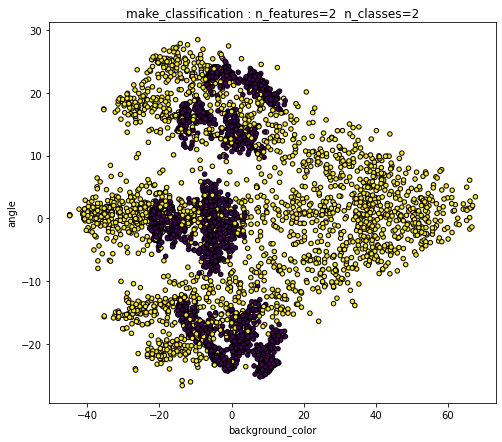

In [1]:
import numpy as np
import cv2
import glob
import os
from sklearn.metrics import accuracy_score
from sklearn import linear_model, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
# ----------------------------------------------------------------------------------------------------------------------
# 分類したいものが入っているディレクトリのなかのOriginalというディレクトリの中に入っている画像を0、
# Fanartというディレクトリの中に入っている画像を1としてラベル付けする
# ----------------------------------------------------------------------------------------------------------------------
DATADIR = "./dataset/afein/"
CATEGORIES = ["Original", "Fanart"]
# ----------------------------------------------------------------------------------------------------------------------
# データセットとして使用するファンアートの枚数、オリジナルイラストの枚数、全体の枚数を指定
# ----------------------------------------------------------------------------------------------------------------------
num_of_data_fanart = 3000
num_of_data_original = 3000
num_of_data_total = num_of_data_original + num_of_data_fanart

# ----------------------------------------------------------------------------------------------------------------------
# 画像サイズと要素数をかけてピクセルデータを生成
# ----------------------------------------------------------------------------------------------------------------------
N_col = 100*100*3

# ----------------------------------------------------------------------------------------------------------------------
# 上記で計算した要素分ゼロ行列を生成する
# ゼロ行列：0で埋められた行列（配列）
# ----------------------------------------------------------------------------------------------------------------------
X_data = np.zeros((num_of_data_total, N_col))
y_data = np.zeros((num_of_data_total))

# ----------------------------------------------------------------------------------------------------------------------
# 生成したゼロ行列を上書きするためのインデックス
# ----------------------------------------------------------------------------------------------------------------------
i_count = 0

# ----------------------------------------------------------------------------------------------------------------------
# データセットを作成する
# ----------------------------------------------------------------------------------------------------------------------
for label, category in enumerate(CATEGORIES):
    path = os.path.join(DATADIR, category+'/')
    for image_name in os.listdir(path):
        try:
            imgPath = path+image_name
            img_array = cv2.imread(imgPath)
            # 多次元リストを1次元のリストにして返す
            img_array = np.ravel(np.array(img_array))
            # 学習データの優先度が一緒になるように値の範囲を小さくしておく
            img_regularized = img_array/255.
            
            # 画像データ、ラベル情報の追加
            X_data[i_count, :] = img_regularized
            y_data[i_count] = label
            # インデックスを1ずつ増加する
            i_count += 1
        except Exception as e:
            pass
        
#-----------------------------------------------------------------------------------------------------------------------
# train_test_split()にndarray型のNumpy配列を渡すと2分割されたndarrayが要素として格納されたリストが返される
# test_sizeでテストデータ(返されるリストの2つ目の要素)の割合を指定できる。
# shuffle：要素をシャッフルして分割するかどうかを指定する。デフォルトはTrueになっている。
# random_state：乱数シード（法則性のない乱数っぽいけどランダムかのように算出されている数値）を指定する。
# 一般的には0か42に設定する。
# startify：均等に分割させたいデータを指定することでデータの値の比率が一致するように分割させる。
#-----------------------------------------------------------------------------------------------------------------------
X_train, y_train, X_test, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=0)

#-----------------------------------------------------------------------------------------------------------------------
# 30000(=100*100*3)の列を100列に落とし込む
#-----------------------------------------------------------------------------------------------------------------------
N_dim = 100

#-----------------------------------------------------------------------------------------------------------------------
# 主成分分析（PCA）：データの分散をなるべく維持しつつ、データの次元を減らす手法。（２次元配列→１次元配列）
# n_components：int,float,Stringの3つで指定することが可能。整数を指定すると圧縮後の次元数となる
#-----------------------------------------------------------------------------------------------------------------------
pca = PCA(n_components=N_dim, random_state=0)

#-----------------------------------------------------------------------------------------------------------------------
# PCAを当てはめて標準化する。()の中は2次元配列のみ可能
#-----------------------------------------------------------------------------------------------------------------------
X_train_pca = pca.fit_transform(X_train)
y_train_pca = pca.transform(y_train)

#-----------------------------------------------------------------------------------------------------------------------
# LinearSVC：線形サポートベクターを使うための関数
# penalty：使用される基準を指定する。l1とl2があり、l1はまばらなベクトルとなる。デフォルト値はl2
# loss：損失関数を指定する。ヒンジ関数が標準であり、penalty='l1'とヒンジ関数はサポートされていない
# class_weight：クラスの重みを指定
# random_state：乱数シードを設定
# max_iter:実行される反復最大数でデフォルトは1000回。反復数が少ないと
# "Liblinear failed to converge, increase"というエラーが出る
#-----------------------------------------------------------------------------------------------------------------------
model = LinearSVC(loss='hinge', C=1.0,class_weight='balanced', random_state=0, max_iter=20000)
#-----------------------------------------------------------------------------------------------------------------------
# モデルに学習させる()の中には訓練データとして指定した画像データと画像ラベルを入力する
#-----------------------------------------------------------------------------------------------------------------------
model.fit(X_train_pca, X_test)

#-----------------------------------------------------------------------------------------------------------------------
# 学習させたモデルにテストデータを入れて正答率を確認する
#-----------------------------------------------------------------------------------------------------------------------
pre = model.predict(y_train_pca)
ac_score=metrics.accuracy_score(y_test, pre)

#-----------------------------------------------------------------------------------------------------------------------
# 検証データの正答率を表示
#-----------------------------------------------------------------------------------------------------------------------
print("正答率：", ac_score)

#-----------------------------------------------------------------------------------------------------------------------
# 学習モデルを.learnファイルとして出力する
#-----------------------------------------------------------------------------------------------------------------------
joblib.dump(model, 'svm.learn')

#-----------------------------------------------------------------------------------------------------------------------
# トレーニングデータの散布図（2D）を表示
#-----------------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
plt.title("make_classification : n_features=2  n_classes=2")
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=X_test, s=20, edgecolor='k')
ax.set_xlabel("background_color")
ax.set_ylabel("angle")
#ax.set_zlabel("Z")
plt.savefig("テストデータ.jpg")
plt.show()

## テスト

正答率： 0.715
[1. 1. 0. 1. 1. 1.]


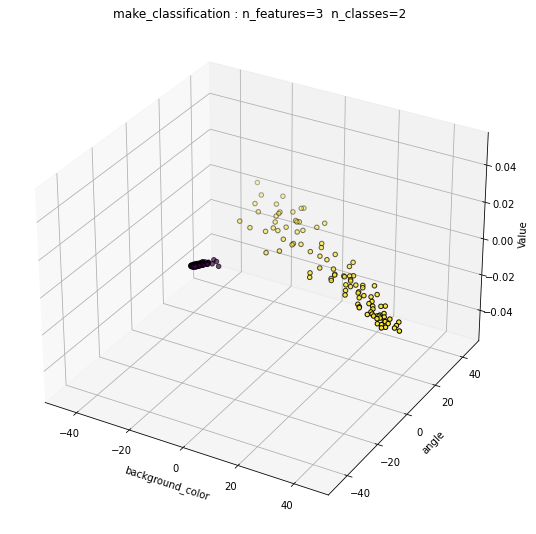

In [102]:
import cv2
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

# ----------------------------------------------------------------------------------------------------------------------
# 分類したいものが入っているディレクトリのなかのOriginalというディレクトリの中に入っている画像を0、
# Fanartというディレクトリの中に入っている画像を1としてラベル付けする
# ----------------------------------------------------------------------------------------------------------------------
DATADIR = "./test/test/"
CATEGORIES = ["Original","Fanart"]

# ----------------------------------------------------------------------------------------------------------------------
# データセットとして使用するファンアートの枚数、オリジナルイラストの枚数、全体の枚数を指定
# ----------------------------------------------------------------------------------------------------------------------
num_of_data_fanart = 100
num_of_data_original = 100
num_of_data_total = num_of_data_fanart+num_of_data_original

N_col = 100*100*3

X_data = np.zeros((num_of_data_total, N_col))
y_data = np.zeros((num_of_data_total))
i_count = 0

for label, category in enumerate(CATEGORIES):
    path = os.path.join(DATADIR, category+'/')
    for image_name in os.listdir(path):
        try:
            imgPath = path+image_name
            img = cv2.imread(imgPath)
            
            img_array = np.ravel(np.array(img))
            
            img_regularized = img_array/255.
            
            X_data[i_count, :] = img_regularized
            y_data[i_count] = label
            i_count += 1
        except Exception as e:
            pass

N_dim = 100

pca = PCA(n_components=N_dim, random_state=0)

X_data_pca = pca.fit_transform(X_data)
#-----------------------------------------------------------------------------------------------------------------------
# ファイルとして出力した学習モデルを読み込む
#-----------------------------------------------------------------------------------------------------------------------
model = joblib.load('svm.learn')
#-----------------------------------------------------------------------------------------------------------------------
# 外部から取り込んだテストデータの正答率を計算
#-----------------------------------------------------------------------------------------------------------------------
score = model.score(X_data_pca, y_data)
print("正答率：", score)

#-----------------------------------------------------------------------------------------------------------------------
# 外部から読み込んだテストデータの散布図(3D)をプロット
#-----------------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8, 7))
ax = Axes3D(fig)
plt.title("make_classification : n_features=3  n_classes=2")
plt.scatter(X_data_pca[:, 0], X_data_pca[:, 1], marker='o', c=y_data, s=20, edgecolor='k')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_xlabel("background_color")
ax.set_ylabel("angle")
ax.set_zlabel("Value")
# 散布図の結果を名前を付けて保存
#plt.savefig("テストデータ3D.jpg")
plt.show()